<a href="https://colab.research.google.com/github/100471975/GRUPO14_Practica2/blob/main/p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Práctica 2

Carlos Seguí Cabrera (100472060)

Rubén de Arriba Viejo (100471975)


Hacemos la importación de librerías y definimos las variables globales que se van a utilizar. Nos aseguramos de limpiar los datos para el correcto procesamiento de los mismos

In [411]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, scale, OneHotEncoder
import copy
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn_extra.cluster import KMedoids
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cdist
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')

def cast_string(string):
    string = string.lower()
    new_string = ""
    for char in string:
        if char not in ["-", " ", "_"]:
            new_string += char
    return new_string


seed = 100471975

## Creación de KMeans
Con los datos ya preparados correctamente, implementamos nuestra propia versión de k-means.
Esta implementación del mismo define los centroides de manera aleatoria, iterando hasta que no varien, asignando cada centroide en función del promedio de los puntos cercanos.

In [412]:
class KMeans_Custom():
  def __init__(self, n_clusters: int, max_iter:int, seed: int):
    if not isinstance(n_clusters, int):
      raise ValueError("El valor de n_clusters debe ser de tipo int")
    if not isinstance(max_iter, int):
      raise ValueError("El valor de max_iter debe ser de tipo int")
    if not isinstance(seed, int):
      raise ValueError("El valor de seed debe ser de tipo int")

    self.n_clusters = n_clusters
    self.max_iter = max_iter
    self.seed = seed
    self.centroids = {}

  def fit(self, dataframe):

    np.random.seed(self.seed)
    centers = dict() # Diccionario con los centroides de cada grupo
    points = [] # Lista de puntos pertenecientes a cada centroide
    iter = 0

    # Seleccionamos aleatoriamente los índices de los primeros puntos usasdos como centroides


    # Seleccionamos los centros
    # El primer centroide lo fijamos aleatoriamente
    random_index = np.random.randint(dataframe.shape[0])
    centers["Centroide1"] = dataframe[random_index]
    # Calculamos la distancia del centro actual al resto de puntos y selecionamos puntos alejados entre si
    for i in range(1, self.n_clusters):
      # Calculamos las distancias de cada punto al centroide más cercano
      distances = np.array([min(np.linalg.norm(centroid - x) for centroid in list(centers.values())[:i])**2 for x in dataframe])
      prob = distances / np.sum(distances)
      next_centroid_index = np.random.choice(range(dataframe.shape[0]), p=prob)
      centers[f"Centroide{i + 1}"] = dataframe[next_centroid_index]
    
    self.centroids = copy.deepcopy(centers)
    while iter < self.max_iter:
      # Si no es la primera iteración se comprueba que los centroides no sean iguales a la iteración anterior
      if iter != 0:
        coincidences = 0
        for i in range(self.n_clusters):
          # Comprobamos los centroides
          if np.array_equal(list(centers.values())[i], list(self.centroids.values())[i]):
            coincidences += 1
        if coincidences == self.n_clusters:
          # Si son iguales detenemos el bucle
          break

      points = []
      for _ in range(self.n_clusters):
        points.append([])
      classes = []
      for row in dataframe:
        # Cogemos un punto de los datos y calculamos que centro es el más cercano
        punto = np.array(row)
        distances_to_centers = [np.linalg.norm(punto - np.array(centroide)) for centroide in centers.values()]
        nearest_center_index = np.argmin(distances_to_centers)
        
        # Añadimos el punto al grupo correspondiente
        points[nearest_center_index].append(punto)
        classes.append(nearest_center_index)
        # Actualizamos el centroide del grupo al que se ha añadido el último punto
      self.centroids = copy.deepcopy(centers)
      for i in range(self.n_clusters):
        # Se actualizan los centros
        centers[f"Centroide{i + 1}"] = np.mean(points[i], axis=0).tolist()
      iter += 1
    return centers, classes

### Comparativa Kmeans

Con nuestro Kmeans creado, vamos a comparar su uso con el Kmeans implementado en sklearn.

Para esto vamos a utilizar make_blobs(), que genera la cantidad de grupos que queramos y es fácilmente representable en una gráfica.

Text(0.5, 1.0, 'Datos simulados')

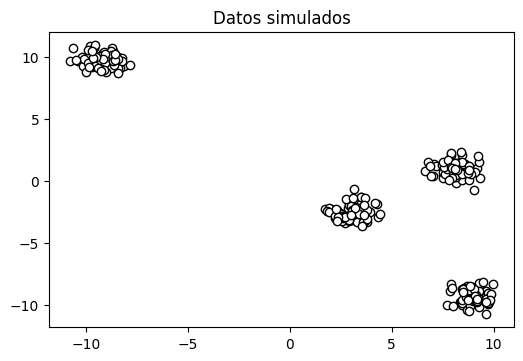

In [413]:
X, y = make_blobs(
    n_samples    = 300,
    n_features   = 2,
    centers      = 4,
    cluster_std  = 0.6,
    shuffle      = True,
    random_state = seed
)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = 'white',
    marker    = 'o',
    edgecolor = 'black',
)
ax.set_title('Datos simulados')

**Kmeans_Custom**

In [414]:
kmeans_custom = KMeans_Custom(4, 20, seed)

kmeans_sklearn = KMeans(n_clusters=4, n_init=20, random_state=seed)
X_scaled = scale(X)
t_inicial_kmeans_custom = time.time()
centers, points = kmeans_custom.fit(X_scaled)
print(f"Tiempo de ejecución de KMeans_Custom = {time.time() - t_inicial_kmeans_custom}s")
t_inicial_kmeans = time.time()
kmeans_sklearn.fit(X=X_scaled)
y_predict_sklearn = kmeans_sklearn.predict(X=X_scaled)
print(f"Tiempo de ejecución de KMeans = {time.time() - t_inicial_kmeans}s")



Tiempo de ejecución de KMeans_Custom = 0.03131413459777832s
Tiempo de ejecución de KMeans = 0.03890681266784668s


Como se puede ver, el tiempo de ejecución de KMeans_Custom es muy similar al tiempo de ejecución de KMeans de sklearn

Mostramos visualmente los cluster originales comparados con los generados por kmeans.

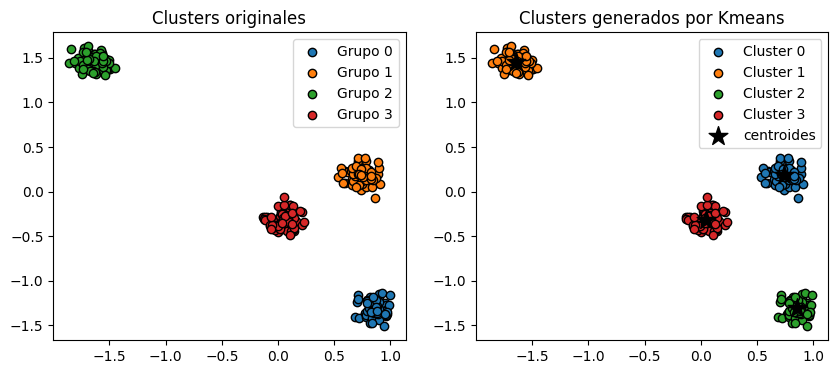

In [415]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_scaled[y == i, 0],
        y = X_scaled[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Grupo {i}"
    )

ax[0].set_title('Clusters originales')
ax[0].legend()

for i in np.unique(y_predict_sklearn):
    ax[1].scatter(
        x = X_scaled[y_predict_sklearn == i, 0],
        y = X_scaled[y_predict_sklearn == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax[1].scatter(
    x = kmeans_sklearn.cluster_centers_[:, 0],
    y = kmeans_sklearn.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax[1].set_title('Clusters generados por Kmeans')
ax[1].legend()

Del mismo modo hacemos la comparativa con nuestro kmeans, como podemos observar este genera un resultaod simila.r

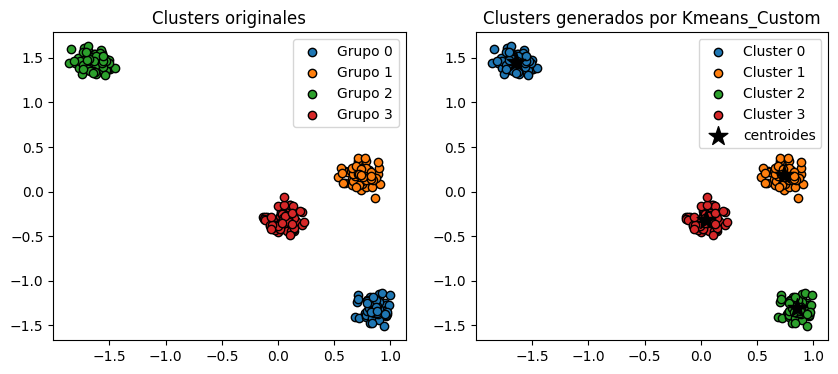

In [416]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_scaled[y == i, 0],
        y = X_scaled[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Grupo {i}"
    )

ax[0].set_title('Clusters originales')
ax[0].legend()

for i in np.unique(points):
    ax[1].scatter(
        x = X_scaled[points == i, 0],
        y = X_scaled[points == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

centers_x = []
centers_y = []
for value in centers.values():
    centers_x.append(value[0])
    centers_y.append(value[1])
ax[1].scatter(
    x = centers_x,
    y = centers_y,
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax[1].set_title('Clusters generados por Kmeans_Custom')
ax[1].legend()

Como puede verse en los graficos, el resultado obtenido por el KMeans de scikit-learn y el KMeans creado por nosotros es idéntico, por lo que damos por válido nuestro modelo KMeans.

Como los tiempos de ejecución son similares y el KMeans de sklearn está más optimizado, vamos a utilizar este para agrupar los datos de la práctica.

## Tratamiento de los datos de entrada
Los datos de entrada son un conjunto de seis atributos, cuatro de ellos son variables continuas y dos de ellos son variables categóricas, por lo que se deben variar estos últimos para poder realizar correctamente el agrupamiento. Además, debido a que el rango de valores de las variables continuas es muy diverso, debemos realizar un escalado de estos atributos.

Como el atributo "Color" de los datos tenía diferentes formatos, se ha creado la función cast_string, que elimina espacios y guiones del string dado como parámetro y lo pone todo en minúsculas. Esto permite que haya una única representación de los colores en los datos.

In [417]:
data = pd.read_csv("Stars2.csv")

for i in range(len(data["Color"])):
    data["Color"][i] = cast_string(data["Color"][i])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB


### Codificación ordinal
Para este tipo de codificación debemos tener en cuenta un orden específico de los atributos. En este caso, los atributos sí que tienen un orden ya que se relaciona su color y clase espectral con la temperatura de la estrella, por lo que podemos definir un orden.

<Axes: title={'center': 'Correlación Ordinal'}>

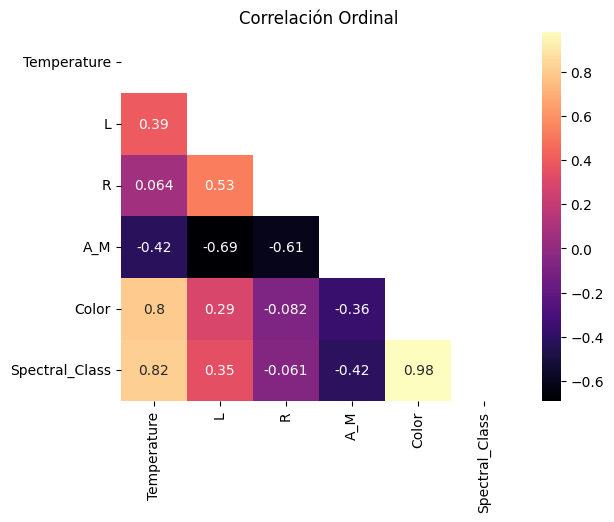

In [418]:
# Codificar los datos cactegóricos según su orden:
data_categoric = copy.deepcopy(data)
color_order = ['red', 'orangered', 'orange', 'paleyelloworange', 'yellowish','yellowwhite','whitish','yellowishwhite','whiteyellow','white','bluewhite','blue']
color_mapping = {color: index for index, color in enumerate(color_order)}

spectral_order = ["M", "K", "G", "F", "A", "B", "O"]
spectral_mapping = {spectral: index for index, spectral in enumerate(spectral_order)}

data_categoric["Color"] = data_categoric["Color"].map(color_mapping)
data_categoric["Spectral_Class"] = data_categoric["Spectral_Class"].map(spectral_mapping)


numeric_columns = data_categoric.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
data_categoric[numeric_columns] = scaler.fit_transform(data_categoric[numeric_columns])


estados = data_categoric.index
corr_df = data_categoric.corr()
etiquetas = corr_df.columns

mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
plt.title("Correlación Ordinal")
sns.heatmap(corr_df, mask=mask_ut, annot=True, cmap="magma")

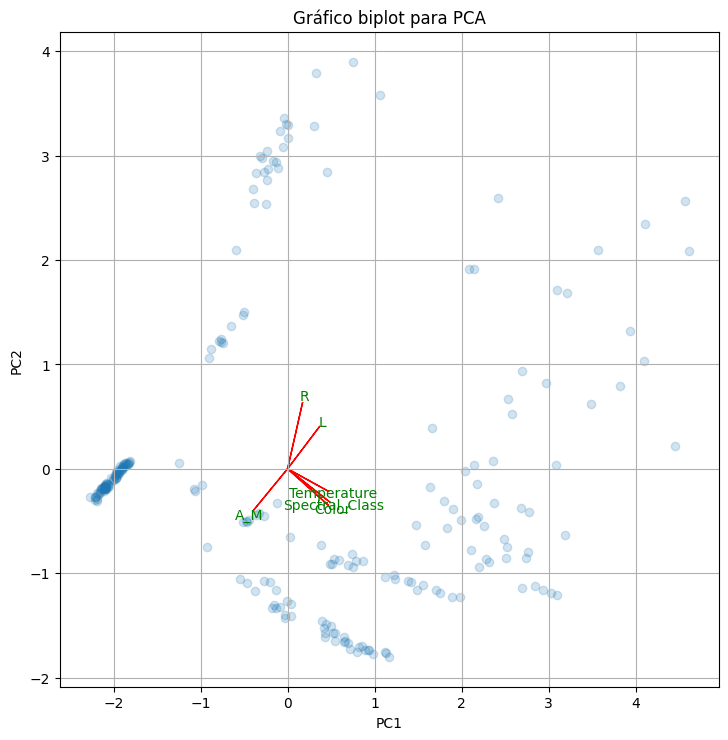

In [419]:
def biplot(scaled_data, fitted_pca, original_dim_labels):

    pca_results = fitted_pca.transform(scaled_data)
    pca1_scores = pca_results[:,0]
    pca2_scores = pca_results[:,1]

    # plot each point in 2D post-PCA space
    plt.scatter(pca1_scores,pca2_scores, alpha=0.2)

    # label each point
    for i in range(len(pca1_scores)):
        plt.text(pca1_scores[i],pca2_scores[i], "")

    #for each original dimension, plot what an increase of 1 in that dimension means in this space
    for i in range(fitted_pca.components_.shape[1]):
        raw_dims_delta_on_pca1 = fitted_pca.components_[0,i]
        raw_dims_delta_on_pca2 = fitted_pca.components_[1,i]
        plt.arrow(0, 0, raw_dims_delta_on_pca1, raw_dims_delta_on_pca2 ,color = 'r',alpha = 1)
        plt.text(raw_dims_delta_on_pca1*1.1, raw_dims_delta_on_pca2*1.1, original_dim_labels[i], color = 'g', ha = 'center', va = 'center')

pca = PCA(n_components=2)

datos_scaled = copy.deepcopy(data)
datos_scaled["Color"] = datos_scaled["Color"].map(color_mapping)
datos_scaled["Spectral_Class"] = datos_scaled["Spectral_Class"].map(spectral_mapping)

datos_scaled = scale(X=datos_scaled, axis=0, with_mean=True, with_std=True)

plt.figure(figsize=(8.5,8.5))
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.title("Gráfico biplot para PCA")
plt.grid()
biplot(datos_scaled, PCA().fit(datos_scaled),
       original_dim_labels=data.columns)

Como se puede ver en los vectores, los atributos Temperature, Color y Spectral_Class están muy correlados, aportanto los 3 prácticamente de igual forma a los dos valores generados en el PCA. Estas tres variables, están muy poco correladas con las variables L y A_M y están ligeramente inversamente correladas con el atributo A.

El atributo A_M esta inversamente relacionada con los atributos R y L, pero sobre todo con el atributo L.

Finalmente, podemos ver que los atributos L y R están bastante correlados.

Podemos ver que el atributo que menos aporta a PC1 es R, que A_M tiene un aporte negativo a esta variable y el resto aportan positivamente a este atributo.

En el caso de PC2, los atributos R y L tienen un aporte positivo, sobre todo R que tiene un aporte prácticamente integro. El resto de variables aportan negativamente a este atributo.

Estas interpretaciones son muy similares a las que se obtienen viendo el gráfico de correlación de los atributos.

### OneHotEncoding
Una alternativa al orden categórico es el OneHotEncoding, que genera un atributo por cada valor de la variable categórica y, si el dato tiene ese atributo, el valor de este es 1 y si no lo tiene es 0, por ejemplo, con la variable categórica "Color", si este puede ser *negro* o *blanco*, se creará el atributo binario *negro* y el atributo binario *blanco*.

<Axes: title={'center': 'Correlación OneHotEncoder'}>

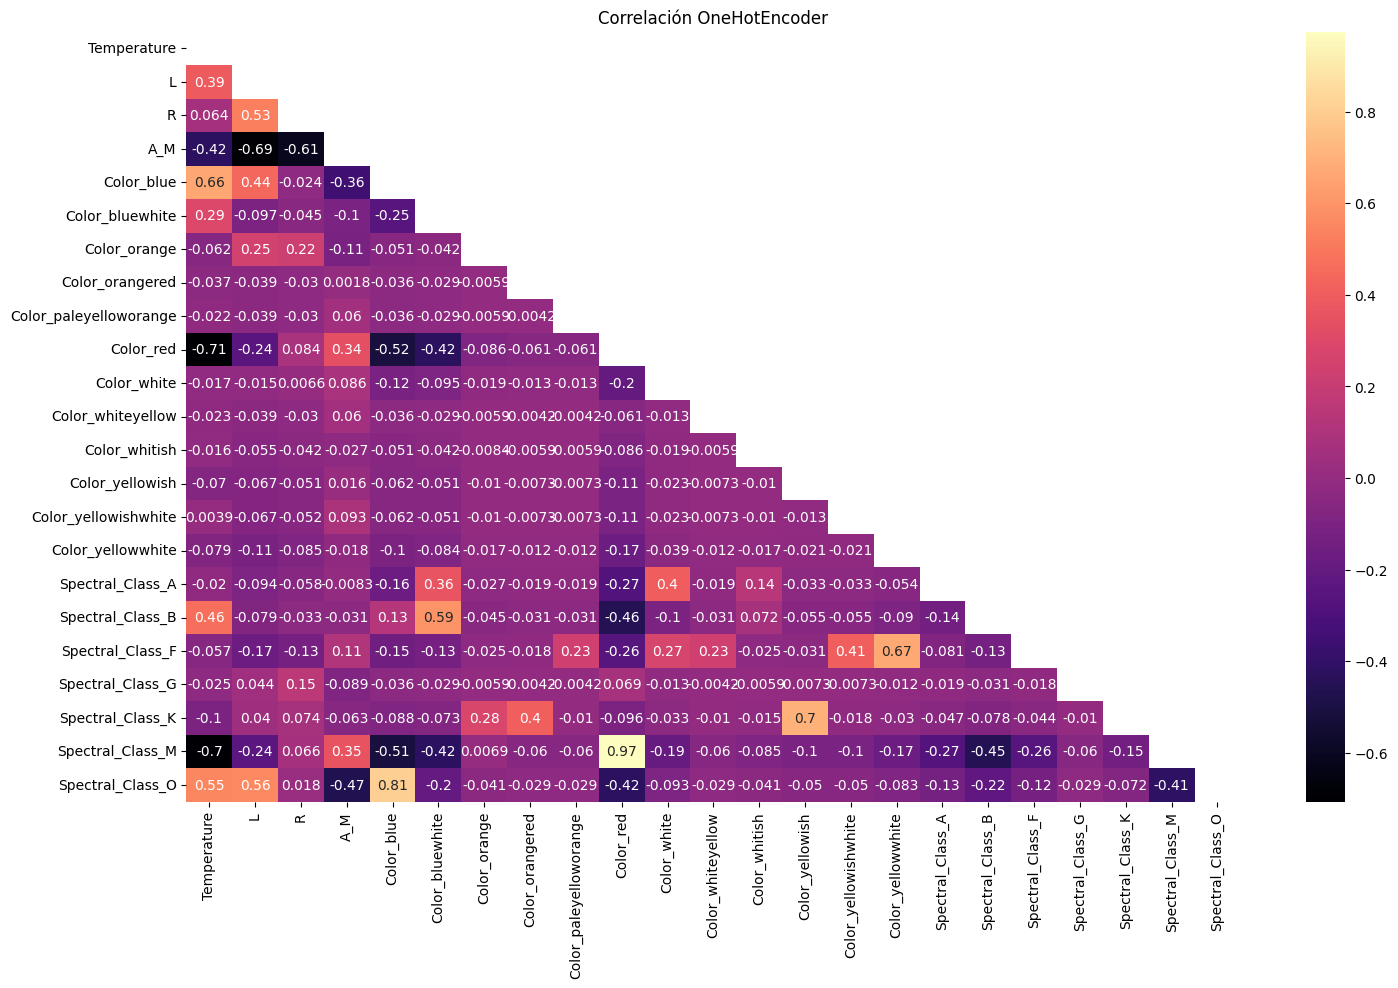

In [420]:
data_OHE = copy.deepcopy(data)

categorical_features = ['Color', 'Spectral_Class']

# Crear el codificador one-hot
encoder = OneHotEncoder()

# Aplicar el codificador a las características categóricas y obtener las nuevas características
encoded_features = encoder.fit_transform(data_OHE[categorical_features])

# Convertir las nuevas características en un DataFrame
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(categorical_features))

# Concatenar las nuevas características codificadas con el DataFrame original
data_OHE = pd.concat([data_OHE.drop(columns=categorical_features), encoded_df], axis=1)


numeric_columns = data_OHE.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
data_OHE[numeric_columns] = scaler.fit_transform(data_OHE[numeric_columns])


estados = data_OHE.index
corr_df = data_OHE.corr()
etiquetas = corr_df.columns

mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
plt.figure(figsize=(17, 10))
plt.title("Correlación OneHotEncoder")
sns.heatmap(corr_df, mask=mask_ut, annot=True, cmap="magma")

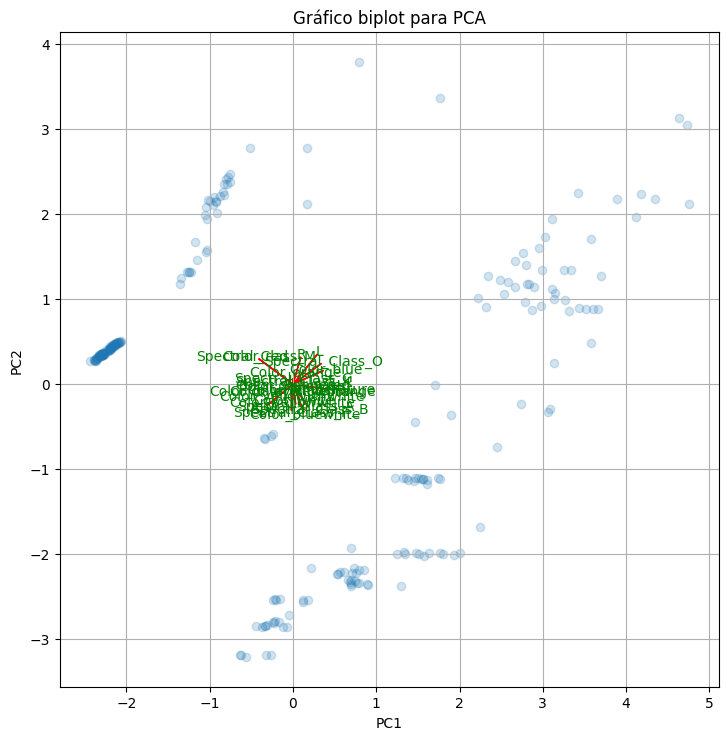

In [421]:
plt.figure(figsize=(8.5,8.5))
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.title("Gráfico biplot para PCA")
plt.grid()
biplot(data_OHE, PCA().fit(data_OHE),
       original_dim_labels=data_OHE.columns)

Como puede verse, de los datos codificados con OneHotEncoder apenas puede interpretarse la correlación que tienen entre ellos, además  este caso con OneHotEncoding no podemos representar todos los grupos, solo algunos.

### PCA
Para que los datos puedan ser representados, tenemos que realizar un PCA de los datos y agruparlos en dos o tres valores.

Proporción de varianza explicada: [0.55409866 0.29691252]
Proporción acumulada: [0.55409866 0.85101118]


<Axes: xlabel='PC1', ylabel='PC2'>

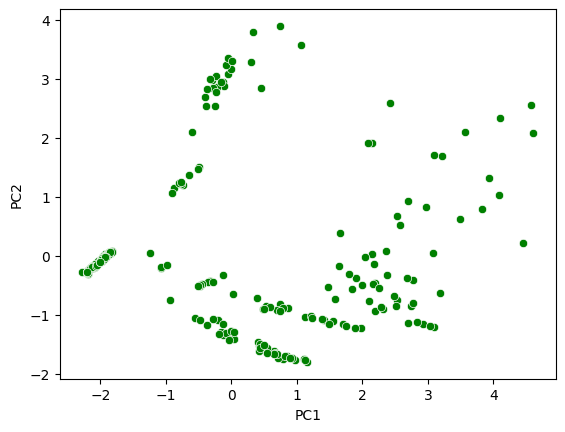

In [422]:
# Codificación ordinal:

pca = PCA(n_components=2)

data_categoric_PCA = pca.fit_transform(data_categoric.values)
print(f"Proporción de varianza explicada: {pca.explained_variance_ratio_}")
print(f"Proporción acumulada: {np.cumsum(pca.explained_variance_ratio_)}")
df_data_categoric_PCA = pd.DataFrame(data_categoric_PCA, columns=["PC1", "PC2"])
sns.scatterplot(data=df_data_categoric_PCA, x="PC1", y="PC2", color='green')

Proporción de varianza explicada: [0.18611084 0.1158609 ]
Proporción acumulada: [0.18611084 0.30197174]


<Axes: xlabel='PC1', ylabel='PC2'>

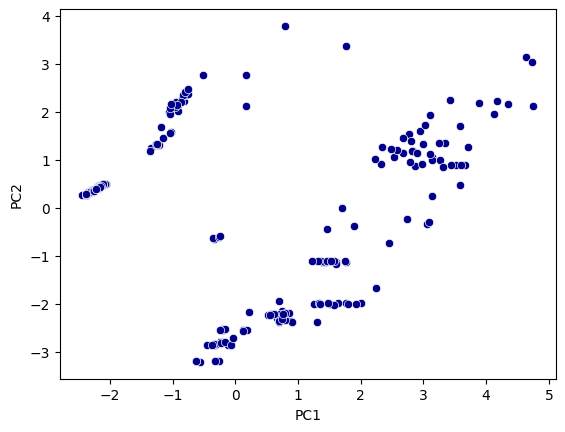

In [423]:
# Codificación OneHotEncoder
pca = PCA(n_components=2)

data_OHE_PCA = pd.DataFrame(pca.fit_transform(data_OHE.values.squeeze()), columns=["PC1", "PC2"])
print(f"Proporción de varianza explicada: {pca.explained_variance_ratio_}")
print(f"Proporción acumulada: {np.cumsum(pca.explained_variance_ratio_)}")
sns.scatterplot(data=data_OHE_PCA, x="PC1", y="PC2", color='darkblue')

Como se puede observar, el grado de explicación de los datos codificados con OneHotEncoder es únicamente del 30%, mientras que la codigicación ordinal tiene una explicabiliadad del 85%. Vamos a probar a generar el modelo pero, en vez de tener 2 componentes vamos a utilizar 3 para ver si esto aumenta significativamente el nivel de explicabilidad.

Proporción de varianza explicada: [0.55409866 0.29691252 0.06395951]
Proporción acumulada: [0.55409866 0.85101118 0.91497069]


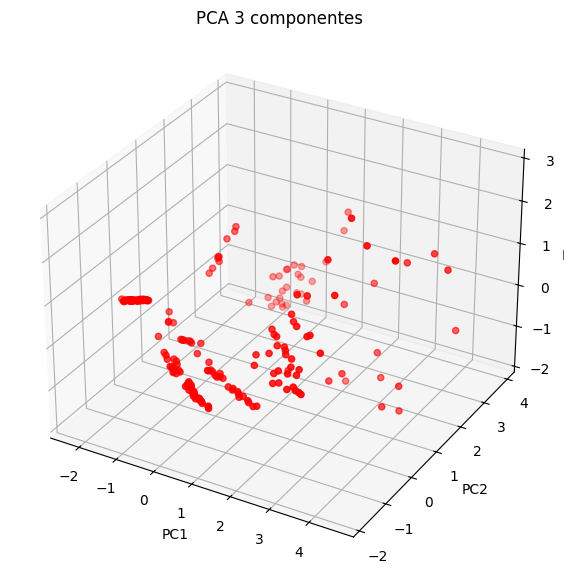

In [424]:
pca = PCA(n_components=3)

aux = pd.DataFrame(pca.fit_transform(data_categoric), columns=["PC1", "PC2", "PC3"])
print(f"Proporción de varianza explicada: {pca.explained_variance_ratio_}")
print(f"Proporción acumulada: {np.cumsum(pca.explained_variance_ratio_)}")
#sns.scatterplot(data=data_categoric_PCA, x="PC1", y="PC2", color='green')
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Agregar puntos al gráfico
ax.scatter(aux['PC1'], aux['PC2'], aux['PC3'], c="r")
plt.title("PCA 3 componentes")
# Etiquetar los ejes
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()


Aunque la explicabilidad del problema aumente hasta el 91%, debido a que es muy complicado representar la información, vamos a utilizar únicamente dos componentes.

## Generación de modelos
Con los datos codificados de una buena forma, podemos empezar a generar modelos y ver cual de ellos es el mejor.

Para esto, debemos evaluar en cada uno de los modelos el número de clusters que optimiza la agrupación. Esto lo vamos a hacer utilizando dos métodos: el método Silhouette y el método del codo (Elbow method). El primero nos da una estimación de cómo funciona un número de clusters dentro del problema mientras que el método del codo nos da un valor de que tan cercanos están los puntos de un cluster al centro del mismo. Agrupando estos dos métodos podremos obtener el número óptimo de clusters.

## KMeans
El primer modelo que vamos a generar es KMeans porque es el que hemos utilizado al principio de la práctica.

**Método del codo**

Text(0, 0.5, 'Intra-cluster (inertia)')

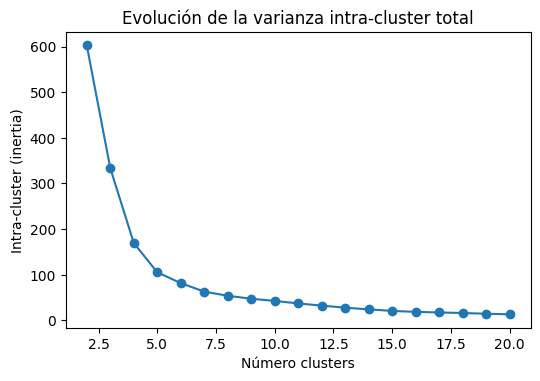

In [425]:
# Aplicamos el método del codo con KMeans
range_n_clusters = range(2, 21)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = seed
    )
    modelo_kmeans.fit(data_categoric_PCA)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)')

Puede verse que a partir de 5 clusters la bajada de la inertia empieza a ser poco significativa, por lo que podemos concluir que el número de clusters sera igual o mayor a 5.

**Silhouette**


Text(0, 0.5, 'Media índices silhouette')

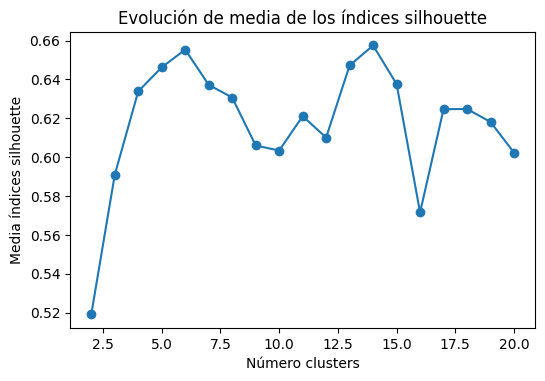

In [426]:
# Hacemos la evaluación Silhouette
range_n_clusters = range(2, 21)
valores_medios_silhouette_kmeans = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = seed
    )
    cluster_labels = modelo_kmeans.fit_predict(data_categoric_PCA)
    silhouette_avg = silhouette_score(data_categoric_PCA, cluster_labels)
    valores_medios_silhouette_kmeans.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette_kmeans, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette')

Siguiendo este método, podemos ver que la mejor cantidad de clusters es de 6 y de 14, por lo que uno de estos dos números es el mejor. Teniendo en cuenta el valor calculado en el método del codo, podemos concluir que con 6 cluster se optimiza el modelo.

### Jerárquico
Siguiendo el mismo sistema de evaluación que para el modelo KMeans, vamos a evaluar el modelo jerárquico

In [427]:
# Para poder representar el resultado, vamos a generar dendrogramas utilizando la siguiente función
def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

Vamos a comprobar cual de los modos de jerárquico es el mejor

**Ward**

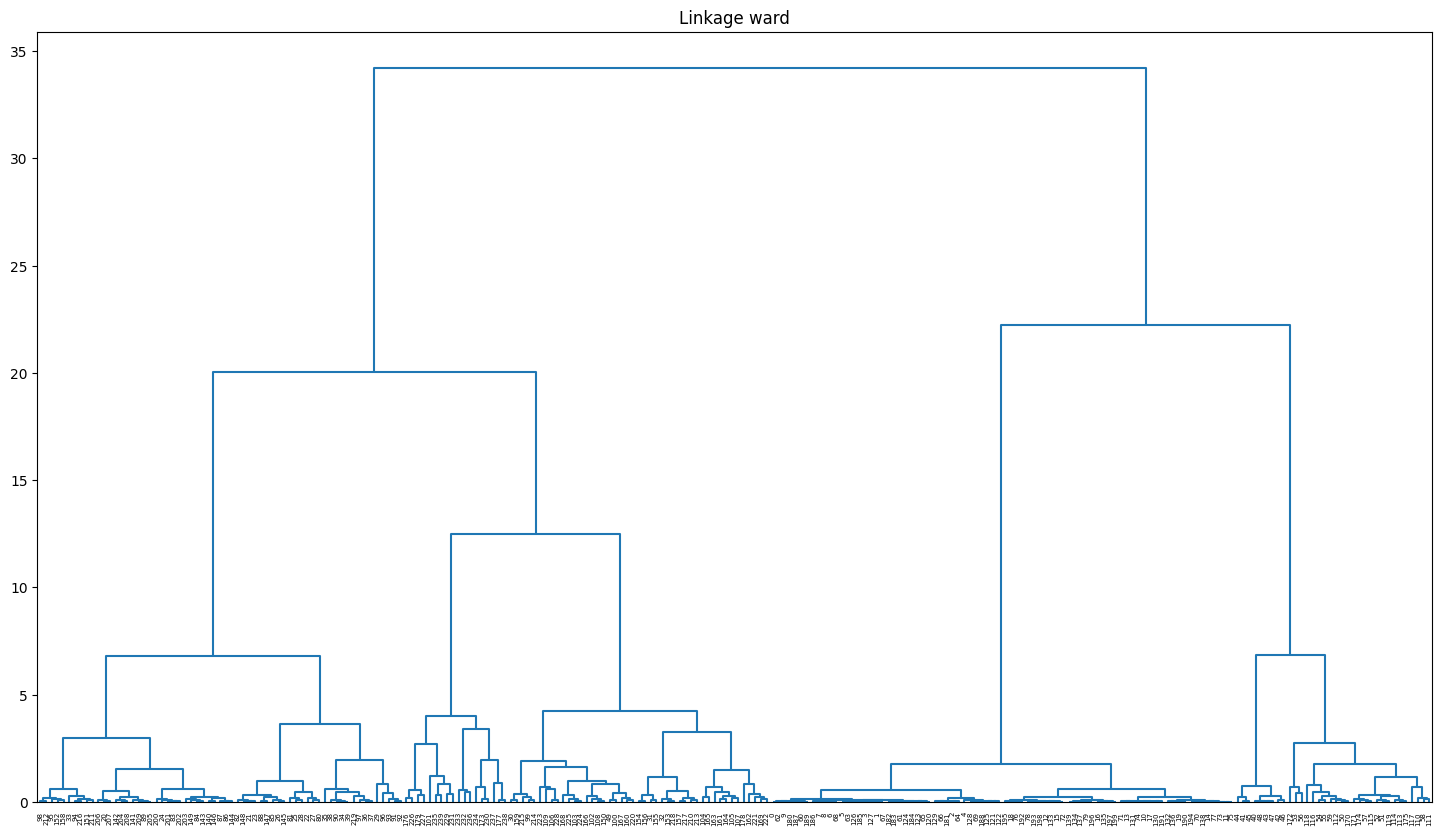

In [428]:
modelo_hclust_ward = AgglomerativeClustering(
    linkage = 'ward',
    distance_threshold = 0,
    n_clusters = None
)
modelo_hclust_ward.fit(X=data_categoric_PCA)
fig, axs = plt.subplots(1, 1, figsize=(18, 10))

plot_dendrogram(modelo_hclust_ward, labels=df_data_categoric_PCA.index, color_threshold=0, ax=axs)

axs.set_title("Linkage ward")
plt.show()

**Método del codo**

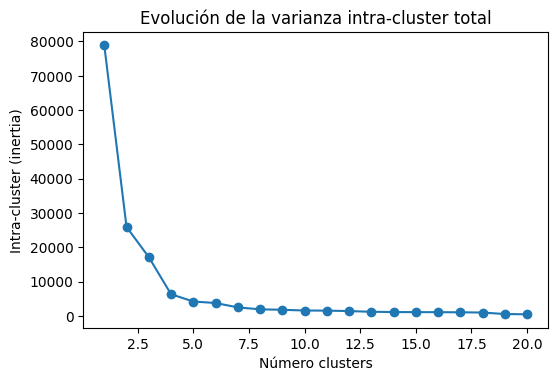

In [429]:
range_n_clusters = range(1, 21)
inertias = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
        linkage='ward',
        n_clusters=n_clusters
    )

    cluster_labels = modelo.fit_predict(data_categoric_PCA)

    # Calcular la matriz de distancias euclidianas entre todos los puntos
    distancias = np.zeros_like(cluster_labels, dtype=float)
    for i in range(len(data_categoric_PCA)):
        for j in range(len(data_categoric_PCA)):
            if cluster_labels[i] == cluster_labels[j]:
                distancias[i] += np.linalg.norm(data_categoric_PCA[i] - data_categoric_PCA[j])

    # Calcular la varianza intra-cluster (suma de distancias intra-cluster)
    inertia = np.sum(distancias) / 2

    inertias.append(inertia)

# Graficar los resultados
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)')
plt.show()


**Silhouette**

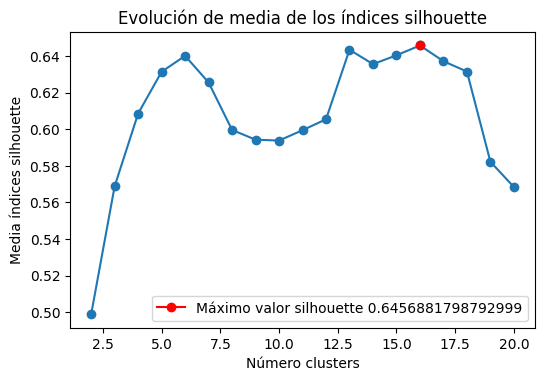

In [430]:
range_n_clusters = range(2, 21)
valores_medios_silhouette_jerarquico_LW = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
        linkage    = 'ward',
        n_clusters = n_clusters
    )

    cluster_labels = modelo.fit_predict(data_categoric_PCA)
    silhouette_avg = silhouette_score(data_categoric_PCA, cluster_labels)
    valores_medios_silhouette_jerarquico_LW.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette_jerarquico_LW, marker='o')

max_silhouette_index = np.argmax(valores_medios_silhouette_jerarquico_LW)
max_silhouette_value = valores_medios_silhouette_jerarquico_LW[max_silhouette_index]

ax.plot(range_n_clusters[max_silhouette_index], max_silhouette_value, marker='o', color='r', label=f'Máximo valor silhouette {max_silhouette_value}')

ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette')
plt.legend()
plt.show()

Según los valores obtenidos, la distancia intra-cluster disminuye suficiente con 5 clusters, pero aplicando el método Silhouette obtenemos que los mejores valores son 6, 13, 15 y 16, pero, teniendo en cuenta la distancia intra-cluster, podemos quedarnos con el valor de 6 clusters.

**Single**

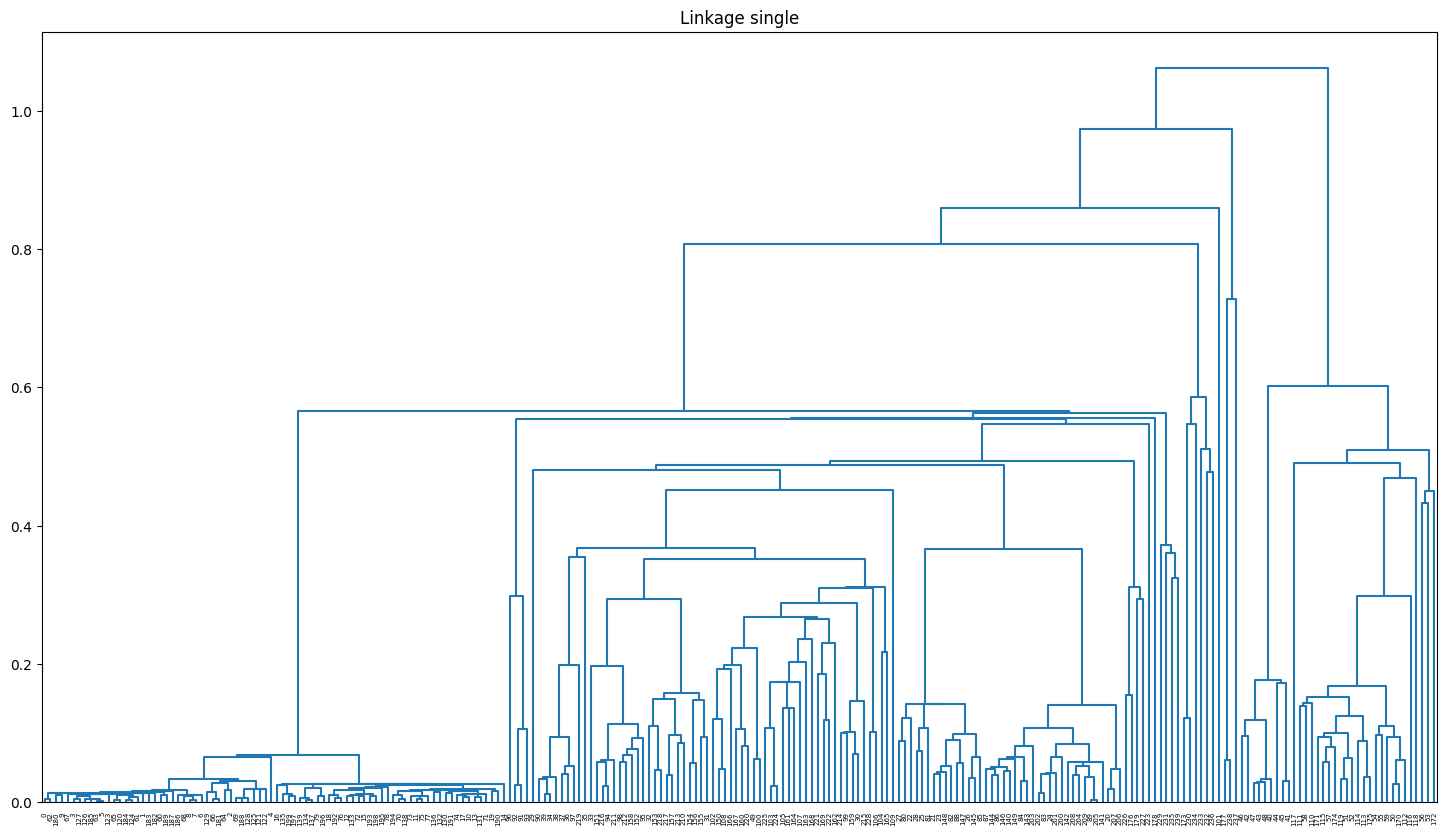

In [431]:
modelo_hclust_single = AgglomerativeClustering(
    linkage = 'single',
    distance_threshold = 0,
    n_clusters = None
)
modelo_hclust_single.fit(X=data_categoric_PCA)
fig, axs = plt.subplots(1, 1, figsize=(18, 10))

plot_dendrogram(modelo_hclust_single, labels=df_data_categoric_PCA.index, color_threshold=0, ax=axs)

axs.set_title("Linkage single")
plt.show()

Consideramos que, teniendo una clasificación que no es ni cercana a óptima, no es necesario evaluar este modelo con el método del codo ni con el método Silhouette.

**Complete**

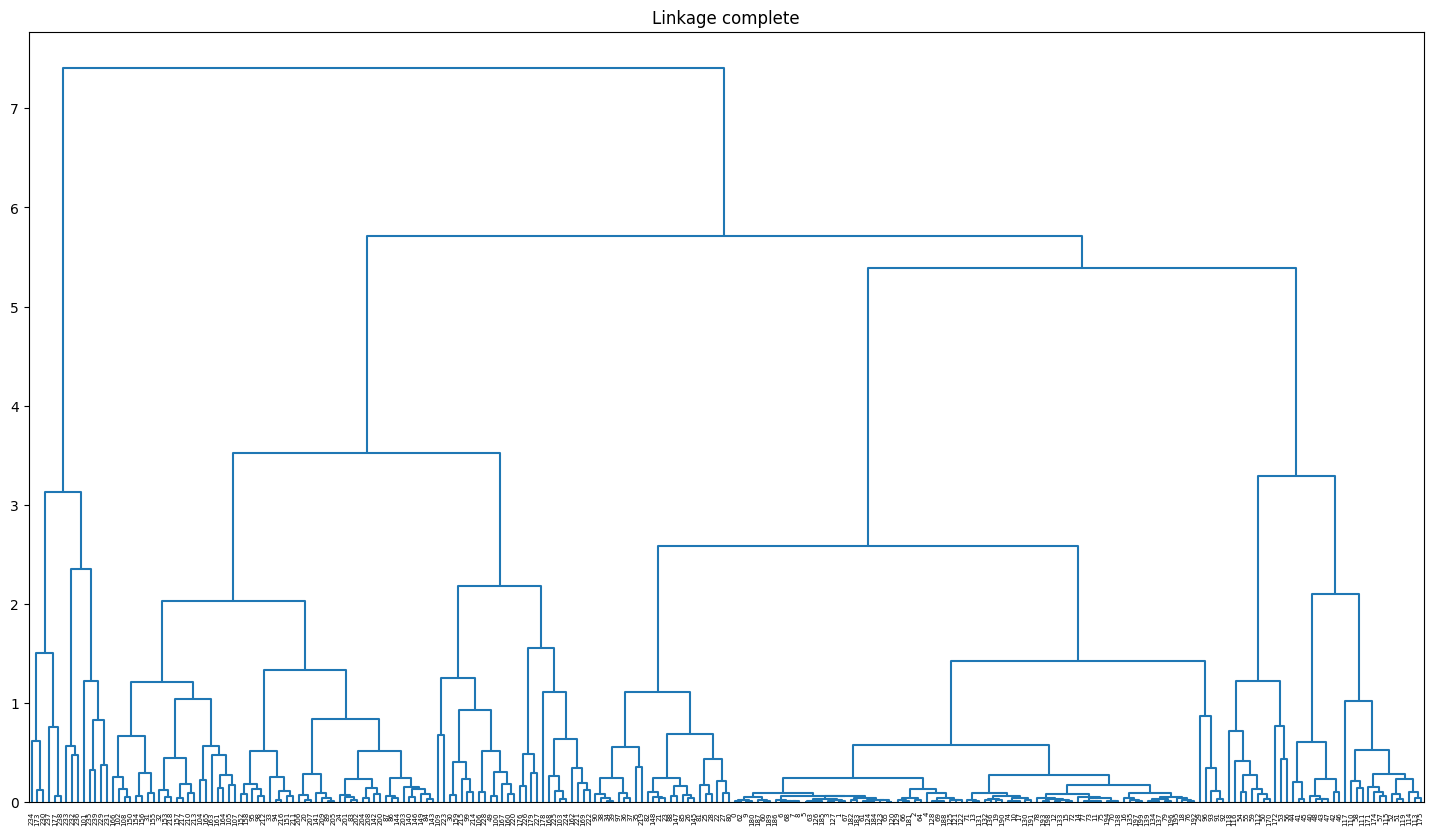

In [432]:
modelo_hclust_complete = AgglomerativeClustering(
    linkage = 'complete',
    distance_threshold = 0,
    n_clusters = None
)
modelo_hclust_complete.fit(X=data_categoric_PCA)
fig, axs = plt.subplots(1, 1, figsize=(18, 10))

plot_dendrogram(modelo_hclust_complete, labels=df_data_categoric_PCA.index, color_threshold=0, ax=axs)

axs.set_title("Linkage complete")
plt.show()

**Método del codo**

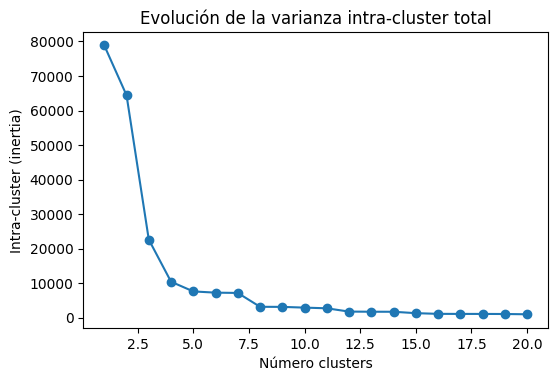

In [433]:
range_n_clusters = range(1, 21)
inertias = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
        linkage='complete',
        n_clusters=n_clusters
    )

    cluster_labels = modelo.fit_predict(data_categoric_PCA)

    # Calcular la matriz de distancias euclidianas entre todos los puntos
    distancias = np.zeros_like(cluster_labels, dtype=float)
    for i in range(len(data_categoric_PCA)):
        for j in range(len(data_categoric_PCA)):
            if cluster_labels[i] == cluster_labels[j]:
                distancias[i] += np.linalg.norm(data_categoric_PCA[i] - data_categoric_PCA[j])

    # Calcular la varianza intra-cluster (suma de distancias intra-cluster)
    inertia = np.sum(distancias) / 2

    inertias.append(inertia)

# Graficar los resultados
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)')
plt.show()


**Silhouette**

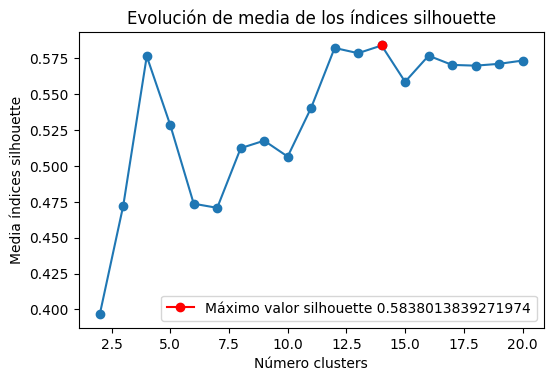

In [434]:
range_n_clusters = range(2, 21)
valores_medios_silhouette_jerarquico_C = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
        linkage    = 'complete',
        n_clusters = n_clusters
    )

    cluster_labels = modelo.fit_predict(data_categoric_PCA)
    silhouette_avg = silhouette_score(data_categoric_PCA, cluster_labels)
    valores_medios_silhouette_jerarquico_C.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette_jerarquico_C, marker='o')

max_silhouette_index = np.argmax(valores_medios_silhouette_jerarquico_C)
max_silhouette_value = valores_medios_silhouette_jerarquico_C[max_silhouette_index]

ax.plot(range_n_clusters[max_silhouette_index], max_silhouette_value, marker='o', color='r', label=f'Máximo valor silhouette {max_silhouette_value}')

ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette')
plt.legend()
plt.show()

El método del codo tiene dos puntos críticos, el 4 y el 7. Esto implica que, a pesar de que con 4, 5 y 6 clusters se obtiene un valor bajo, a partir de 7 clusters este es ligeramente inferior. Sin embargo, al fijarmos en los valores obtenidos por el método silhouette, podemos comprobar que los mejores valores son 4, 12, 13 y 14. Hemos considerado dar 12 clusters como valor óptimo de clusters porque da uno de los mejores valores tanto en el método silhouette como en el método del codo.

**Average**

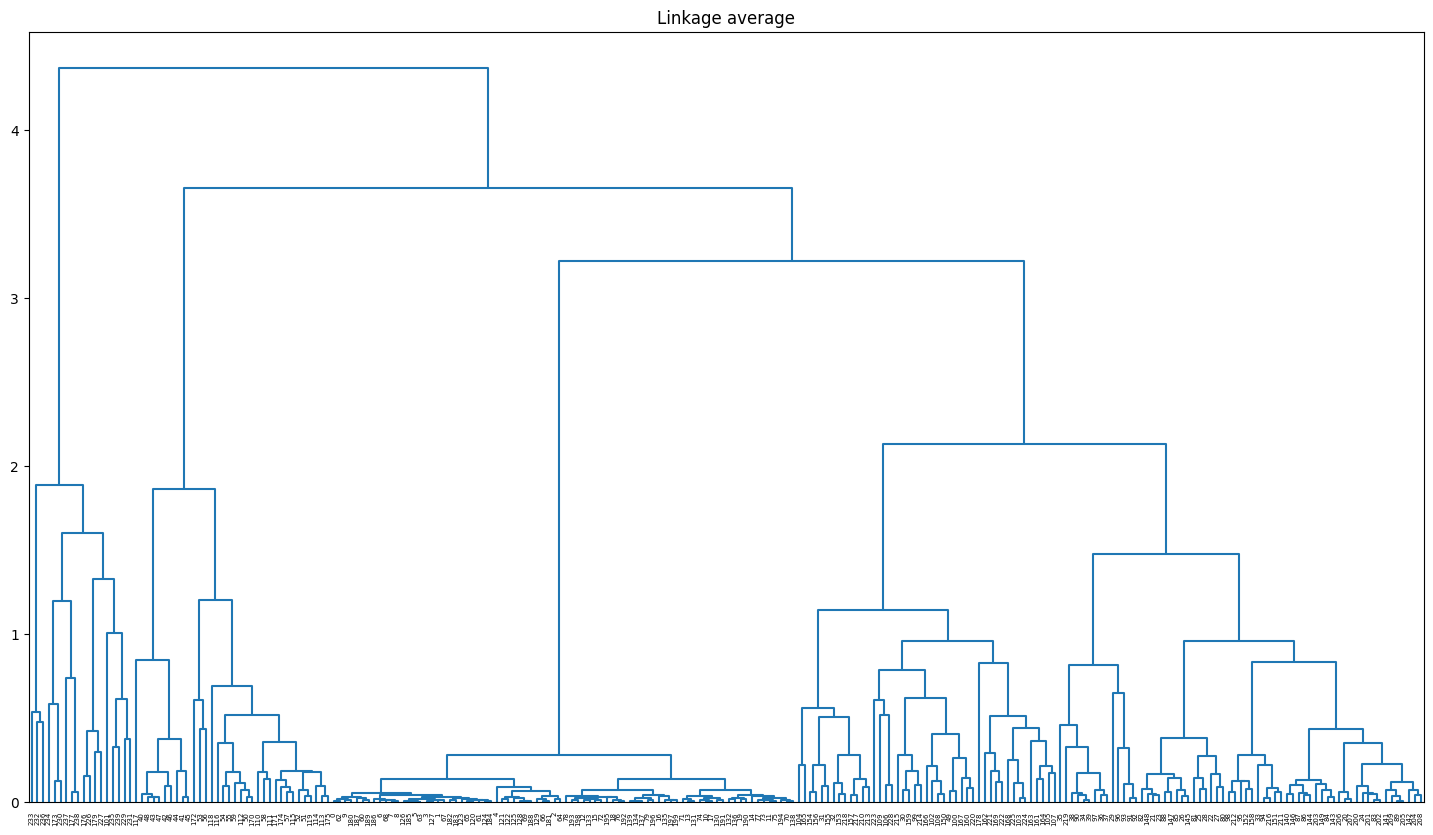

In [435]:
modelo_hclust_average = AgglomerativeClustering(
    linkage = 'average',
    distance_threshold = 0,
    n_clusters = None
)
modelo_hclust_average.fit(X=data_categoric_PCA)
fig, axs = plt.subplots(1, 1, figsize=(18, 10))

plot_dendrogram(modelo_hclust_average, labels=df_data_categoric_PCA.index, color_threshold=0, ax=axs)

axs.set_title("Linkage average")
plt.show()

**Método del codo**

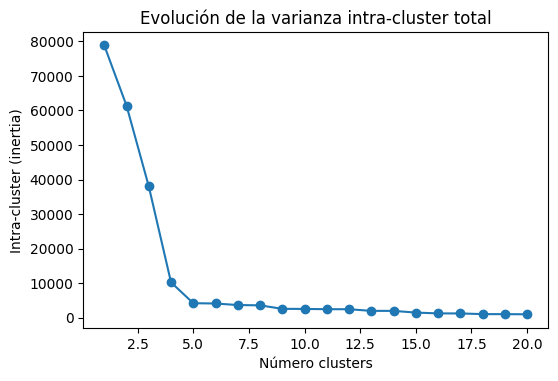

In [436]:
range_n_clusters = range(1, 21)
inertias = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
        linkage='average',
        n_clusters=n_clusters
    )

    cluster_labels = modelo.fit_predict(data_categoric_PCA)

    # Calcular la matriz de distancias euclidianas entre todos los puntos
    distancias = np.zeros_like(cluster_labels, dtype=float)
    for i in range(len(data_categoric_PCA)):
        for j in range(len(data_categoric_PCA)):
            if cluster_labels[i] == cluster_labels[j]:
                distancias[i] += np.linalg.norm(data_categoric_PCA[i] - data_categoric_PCA[j])

    # Calcular la varianza intra-cluster (suma de distancias intra-cluster)
    inertia = np.sum(distancias) / 2

    inertias.append(inertia)

# Graficar los resultados
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)')
plt.show()


**Silhouette**

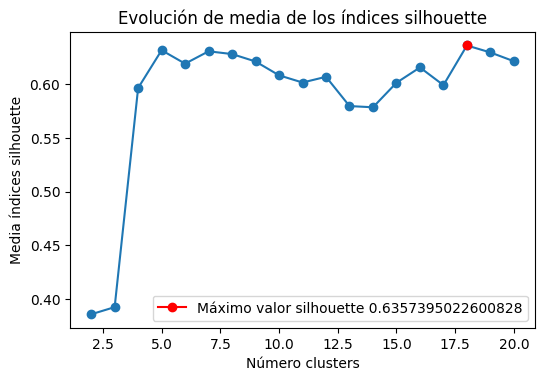

In [437]:
range_n_clusters = range(2, 21)
valores_medios_silhouette_jerarquico_A = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
        linkage    = 'average',
        n_clusters = n_clusters
    )

    cluster_labels = modelo.fit_predict(data_categoric_PCA)
    silhouette_avg = silhouette_score(data_categoric_PCA, cluster_labels)
    valores_medios_silhouette_jerarquico_A.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette_jerarquico_A, marker='o')

max_silhouette_index = np.argmax(valores_medios_silhouette_jerarquico_A)
max_silhouette_value = valores_medios_silhouette_jerarquico_A[max_silhouette_index]

ax.plot(range_n_clusters[max_silhouette_index], max_silhouette_value, marker='o', color='r', label=f'Máximo valor silhouette {max_silhouette_value}')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette')
plt.legend()
plt.show()

Aunque el valor máximo se obtenga con 18 clusters, debido a los datos obtenidos por el método del codo, podemos obtener que a partir de 5 clusters la clasificación ya es suficientemente buena, por lo que nos quedamos con el valor de 6 para el número de clusters porque su valor silhouette es ligeramente mayor al obtenido con 5 clusters y es de los más altos del gráfico.

**Comparativa Silhouette**

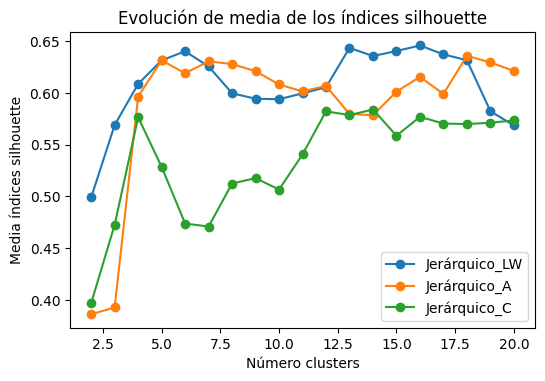

In [438]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette_jerarquico_LW, marker='o', label="Jerárquico_LW")
ax.plot(range_n_clusters, valores_medios_silhouette_jerarquico_A, marker="o", label="Jerárquico_A")
ax.plot(range_n_clusters, valores_medios_silhouette_jerarquico_C, marker="o", label="Jerárquico_C")
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette')
plt.legend()
plt.show()

Comparando los valores silhouette obtenidos en los tres métodos, podemos ver que el método ward es el que obtiene mejores valores, por lo que va a ser el modelo que vamos a usar como representación de la clasificación jerárquica.

### KMedoids
Vamos a realizar el análisis del modelo KMedoids, que es más costoso computacionalmente pero es menos sensible a datos atípicos

**Método del codo**

Text(0, 0.5, 'Intra-cluster (inertia)')

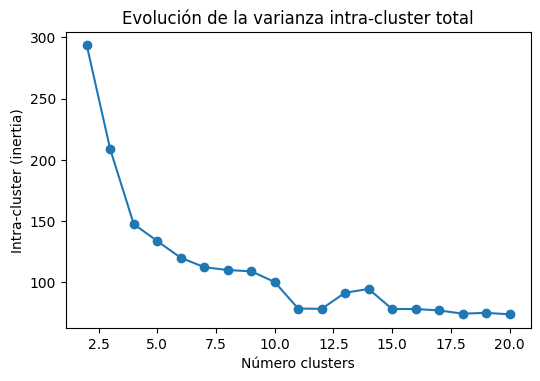

In [439]:
range_n_clusters = range(2, 21)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmedoids = KMedoids(
        n_clusters   = n_clusters,
        random_state = seed
    )
    modelo_kmedoids.fit(data_categoric_PCA)
    inertias.append(modelo_kmedoids.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)')

**Silhouette**

Text(0, 0.5, 'Media índices silhouette')

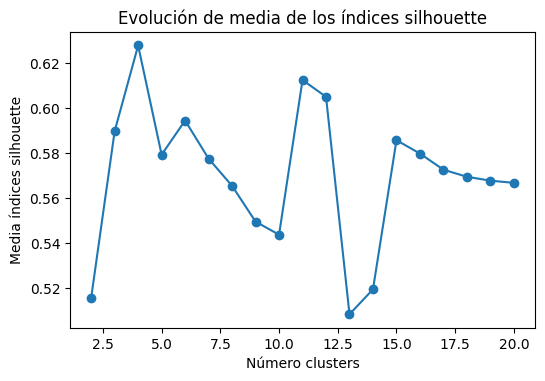

In [440]:
range_n_clusters = range(2, 21)
valores_medios_silhouette_kmedoids = []

for n_clusters in range_n_clusters:
    modelo_kmedoids = KMedoids(
        n_clusters   = n_clusters,
        random_state = seed,
        
    )
    cluster_labels = modelo_kmedoids.fit_predict(data_categoric_PCA)
    silhouette_avg = silhouette_score(data_categoric_PCA, cluster_labels)
    valores_medios_silhouette_kmedoids.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette_kmedoids, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette')

## DBSCAN
Vamos analizar el modelo DBSCAN porque este algoritmo, en vez de agrupar en base a ciertos centros, agrupa según la densidad de los puntos del problema.

**Método del codo**

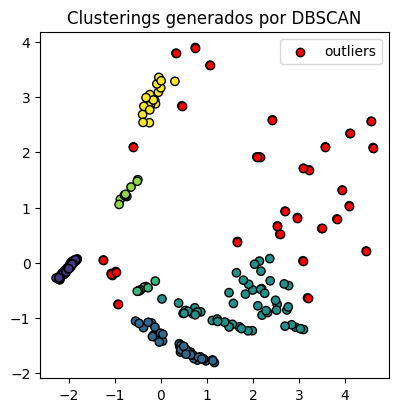

Número de clusters encontrados: 6
Número de outliers encontrados: 31


In [441]:
modelo_dbscan = DBSCAN(
    eps          = 0.4,
    min_samples  = 5,
    metric       = 'euclidean',
)

modelo_dbscan.fit(data_categoric_PCA)
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = data_categoric_PCA[:, 0],
    y = data_categoric_PCA[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = data_categoric_PCA[labels == -1, 0],
    y = data_categoric_PCA[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN')
plt.show()
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

Aún habiendo probado con numerosos valores para eps y para min_samples, no se puede obtener una buena clasificación, por lo que descartamos este método de clustering.

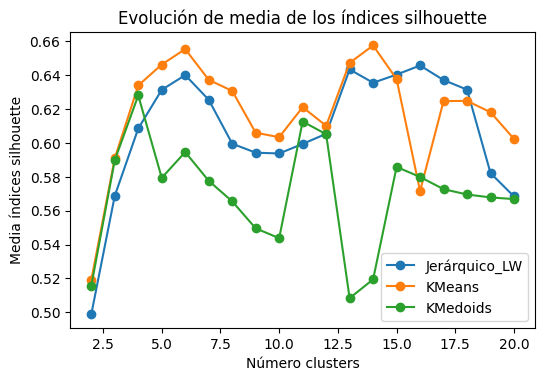

In [442]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette_jerarquico_LW, marker='o', label="Jerárquico_LW")
ax.plot(range_n_clusters, valores_medios_silhouette_kmeans, marker="o", label="KMeans")
ax.plot(range_n_clusters, valores_medios_silhouette_kmedoids, marker="o", label="KMedoids")
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette')
plt.legend()
plt.show()

Comparando las gráficas de las medidas silhouette de cada uno de los modelos, podemos ver que el mejor resultado para el número de clusters es de 6, por lo que vamos a dibujar como quedaría con cada uno de los modelos la clasificación.

## Clasificación

### KMeans


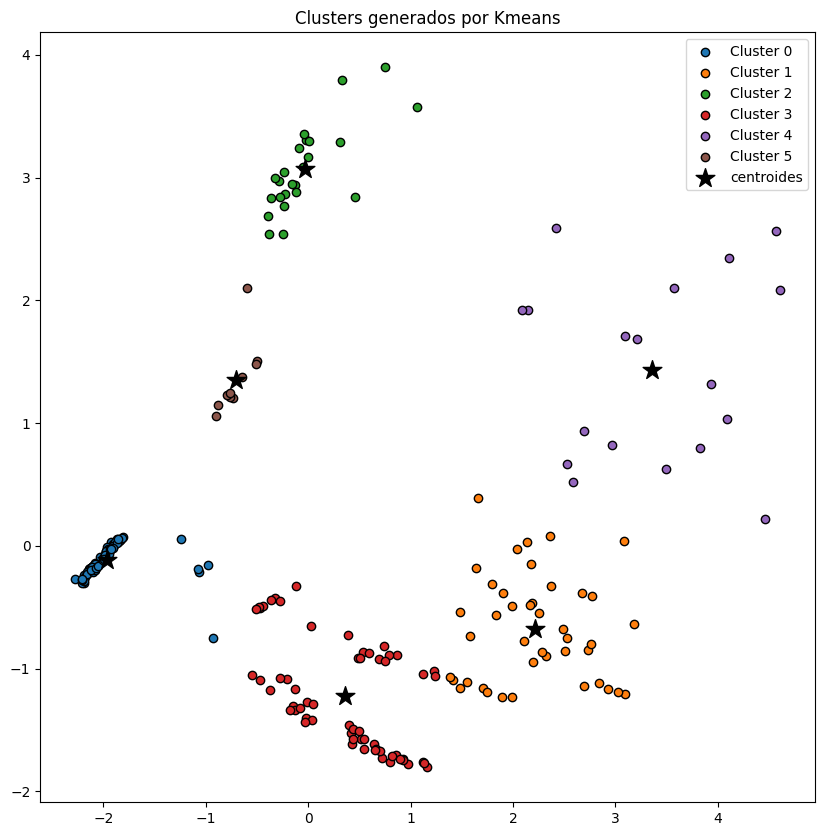

In [443]:
modelo_kmeans = KMeans(
        n_clusters   = 6,
        n_init       = 20,
        random_state = seed
)

modelo_kmeans.fit(data_categoric_PCA)
y_predict_kmeans = modelo_kmeans.predict(data_categoric_PCA)




fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i in np.unique(y_predict_kmeans):
    ax.scatter(
        x = data_categoric_PCA[y_predict_kmeans == i, 0],
        y = data_categoric_PCA[y_predict_kmeans == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax.scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax.set_title('Clusters generados por Kmeans')
ax.legend()
plt.show()

### Jerárquico

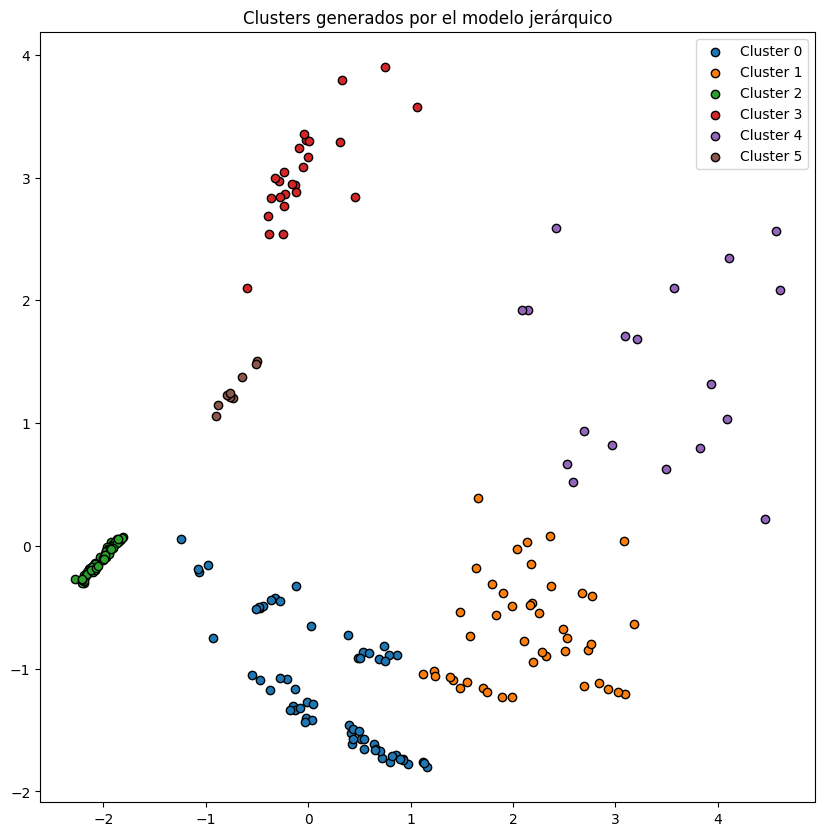

In [444]:
modelo_jerarquico = AgglomerativeClustering(
        linkage    = 'ward',
        n_clusters = 6,
)
y_predict_sklearn = modelo_jerarquico.fit_predict(data_categoric_PCA)




fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i in np.unique(y_predict_sklearn):
    ax.scatter(
        x = data_categoric_PCA[y_predict_sklearn == i, 0],
        y = data_categoric_PCA[y_predict_sklearn == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )
ax.set_title('Clusters generados por el modelo jerárquico')
ax.legend()
plt.show()

### KMedoids


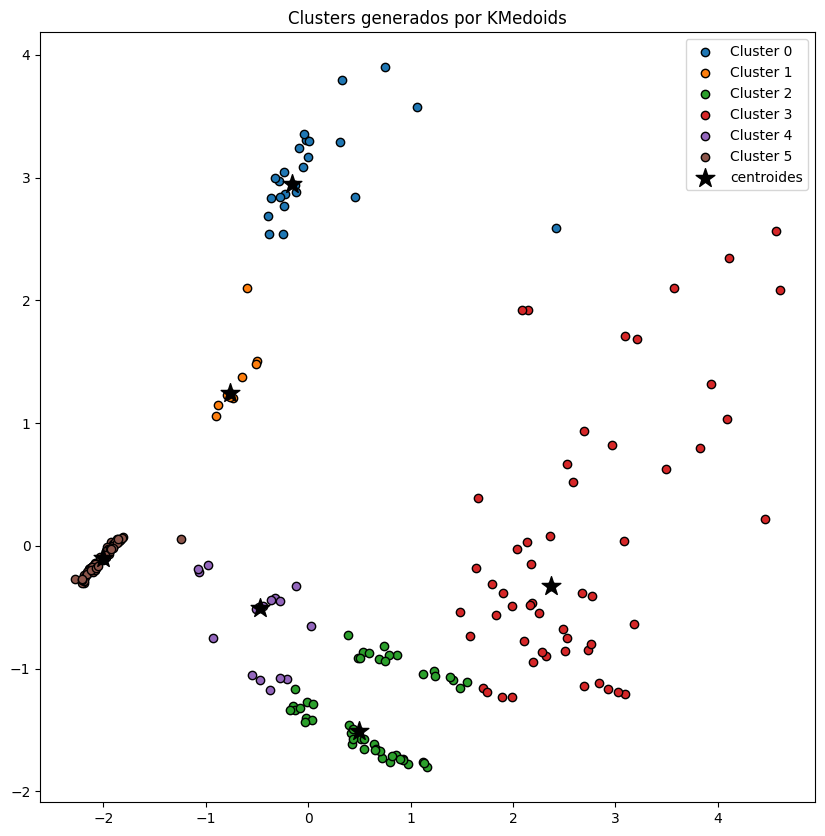

In [445]:
modelo_kmedoids = KMedoids(
        n_clusters   = 6,
        random_state = seed
)

modelo_kmedoids.fit(data_categoric_PCA)
y_predict_sklearn = modelo_kmedoids.predict(data_categoric_PCA)




fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i in np.unique(y_predict_sklearn):
    ax.scatter(
        x = data_categoric_PCA[y_predict_sklearn == i, 0],
        y = data_categoric_PCA[y_predict_sklearn == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax.scatter(
    x = modelo_kmedoids.cluster_centers_[:, 0],
    y = modelo_kmedoids.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax.set_title('Clusters generados por KMedoids')
ax.legend()
plt.show()

Observando las clasificaciones generadas, podemos ver que tanto el modelo KMeans como el modelo Jerárquico agrupan de igual manera los datos del problema. Sin embargo, el modelo de KMedoids genera una clasificación muy diferente. Para saber cual de estas clasificaciones es mejor, debemos saber los valores de cada uno de los puntos y ver a qué grupo de estrellas pertenece, ya el número óptimo de grupos que nos han salido es el mismo que tienen los científicos tienen para clasificar las estrellas.

A simple vista, consideramos que la clasificación de los dos primeros modelos son los que mejor clasifican las estrellas, ya que se puede ver que los grupos mucho menos dispersos. Esto se nota, sobre todo, en el Cluster 3 del modelo KMedoids.

## Discusión grupos obtenidos

Para evaluar la clasificación, vamos a evaluar la clasificación realizada por KMeans y Kmedoids

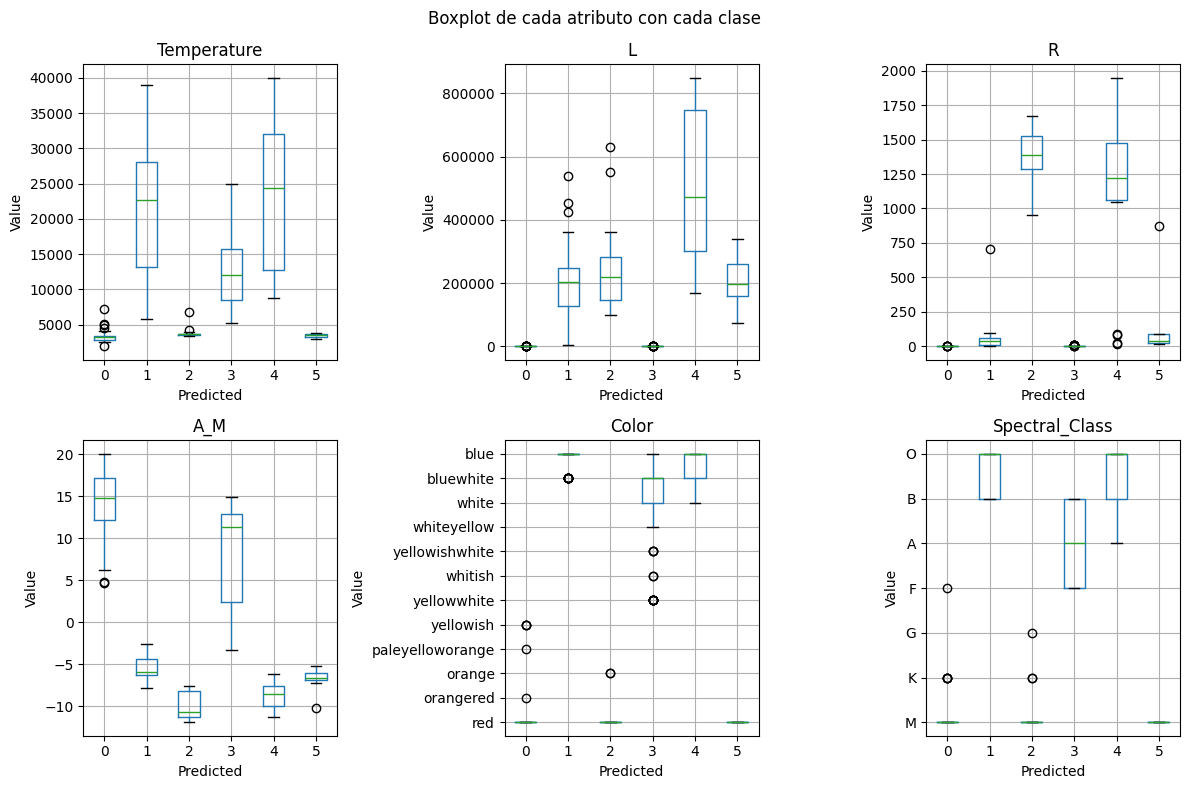

In [446]:
data_categoric = copy.deepcopy(data)
color_order = ['red', 'orangered', 'orange', 'paleyelloworange', 'yellowish','yellowwhite','whitish','yellowishwhite','whiteyellow','white','bluewhite','blue']
color_mapping = {color: index for index, color in enumerate(color_order)}

spectral_order = ["M", "K", "G", "F", "A", "B", "O"]
spectral_mapping = {spectral: index for index, spectral in enumerate(spectral_order)}

data_categoric["Color"] = data_categoric["Color"].map(color_mapping)
data_categoric["Spectral_Class"] = data_categoric["Spectral_Class"].map(spectral_mapping)

data_predicted = pd.concat([data_categoric, pd.Series(y_predict_kmeans, name="predictions")],axis = 1)
plt.figure(figsize=(12, 8))

for column in data_categoric.columns:
        ax = plt.subplot(2, 3, data_categoric.columns.get_loc(column) + 1)
        data_predicted.boxplot(column=column, by="predictions", ax=ax)
        plt.title(column)
        plt.xlabel("Predicted")
        if column == "Color":
                plt.yticks(range(len(color_order)), color_order)
        elif column == "Spectral_Class":
                plt.yticks(range(len(spectral_order)), spectral_order)
        plt.ylabel("Value")
        plt.suptitle("Boxplot de cada atributo con cada clase")

plt.tight_layout()
plt.show()


Teniendo ya estos valores vamos a ver los valores que obtenemos para las clases(Kmeans):

Clase_0: {Temperature: <5000, L: 0, R: 0, A_M: [12.5, 17], Color: red, Spectral_Class: M}

Clase_1: {Temperature: [14000, 27000], L: [15000, 25000], R: [0, 100], A_M: [-7, -4], Color: blue, Spectral_Class: B-O}

Clase_2: {Temperature: <5000, L: [17000, 30000], R: [1200, 1500], A_M: [-11, -8], Color: red, Spectral_Class: M}

Clase_3: {Temperature: [8500, 15000], L: 0, R: 0, A_M: [3, 12.5], Color: white-bluewhite, Spectral_Class: F-B}

Clase_4: {Temperature: [14000, 32000], L: [32000, 75000], R: [1050, 1500], A_M: [-10, -8.5], Color: blue-bluewhite, Spectral_Class: B-O}

Clase_5: {Temperature: <5000, L: [18000, 27000], R: [0, 100], A_M: [-7, -6], Color: red, Spectral_Class: M}

Haciendo una comparativa con las clases de estrellas definidas por Morgan-Keenan [M, K, G, F, A, B, O] y el sistema de clasificación de harvard obtenemos las siguientes conclusiones:
Las clases 0,2,5 se aproximarian  a estrellas de tipo M(strellas relativamente frías y tienen baja luminosidad) ; mientras la 1,4 a estellas de tipo B,O (estrellas calientes y brillantes) y la clase 3 a estrellas de tipo F,B (estrellas más calientes y luminosas que las estrellas de tipo M.)

Como podemos ver y hemos comentado antes la representación es más olgada con Kmeans que con Kmedoids, aunque al comparar con la representación cientifica, puede resultar un poco radicalizada, esto puede deberse a la muestra, sin embargo, la clasifiación tiene sentido, ya que es cercana a esta, y más teniendo en cuenta que la clasificación espectral se refiere a una clasifiación por temperatura superficial con subtipos estimados, cuyos intervalos no son matemáticamente represebtables.

Comparando las clases obtenidas con la clasificación del enunciado de la práctica, podemos ver que la clase 0 tiene gran similitud con las dos primeras clases en la tabla del enunciado (enanas roja y marron).

La clase 1 se asemeja bastante a la clase de estrellas super gigantes a excepción del radio, que no encaja demasiado bien.

La clase 2 es similar a la clase de hiper gigantes salvo por la temperatura, que es poco parecido el valor obtenido.

La clase 3 podría adecuarse a la clase de enana blanca, ya que todos sus valores son similares a excepción de la temperatura.

La clase 4 podría ser una agrupación de estrellas super gigantes e hiper gigantes a excepción de la clase epectral, que no concuerda mucho el valor obtenido.

La clase 5 parece tener valores que se adaptan a toda clase de estrellas. Por ejemplo, si miramos su temperatura, R y Color podría ser una enana roja o marron. Sin embargo, mirando el resto de atributos, podría entrar dentro del grupo de estrellas super gigantes.